## Optimal Causation Entropy (oCSE)
Optimal causation entropy is a reconstruction method of networks from time series data proposed by **[Sun _et al._](https://epubs.siam.org/doi/10.1137/140956166)** (2015). The algorithm finds the causal parents for every node based on a Theorem 2.3 in [1], which states that a node $i$'s causal parents is the minimal set $J$ such that the causation entropy $C_{K \rightarrow i}$ from $J$ to $i$ is maximized. The gereral form of causation entropy (from nodes $J$ to nodes $I$ conditioning on nodes $K$) is defined as

$$C_{J \rightarrow I | K} ~=~ H\left(X_{t+1}^{(I)} | X_t^{(K)}\right) - H\left(X_{t+1}^{(I)} | X_t^{(K)}, X_t^{(J)}\right)$$

where $H$ is the conditional entropy and $X_t^{(K)}$ is the random variable of state on a set of nodes $K$ at time $t$. Here we use $C_{J \rightarrow i}$ as a abbreviation of $C_{J \rightarrow \{i\} | \emptyset}$.

**[Sun _et al._](https://epubs.siam.org/doi/10.1137/140956166)** further proved that the minimal set of nodes maximizing causation entropy can be found by first obtaining a superset of the causal parents through a heuristic and then removing non-causal nodes from this superset. This strategy attempts to avoid computing entropy accross a large number of variables and is in theory exact to reconstruct networks upon which the stochastic process is Markovain. However, the current implementation suffers from sensitivity to hyperparameters.

### Examples of oCSE
Let's define some help functions to generate ring-of-clique networks and time series data from a Ising model:

In [1]:
import numpy as np
from numpy.random import rand
import networkx as nx
from netrd.reconstruction import OptimalCausationEntropyReconstructor
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def four_clique_adjmat(N):
    """Return the adjacency matrix of a network consisting of a ring of 4 cliques."""
    n_cliques = 4
    G = nx.ring_of_cliques(n_cliques, N // n_cliques).to_directed()
    A = nx.to_numpy_array(G)
    
    return A

In [3]:
def time_series(adjmat, n_steps):
    """Return synthetic time series data from simulating a Ising model on the given network."""
    n_nodes, _ = adjmat.shape
    data = np.ones((n_steps, n_nodes), dtype=float)  # Initially all spin up
    
    # Transition matrix where [i, j] element is the transition probability
    # from node i to node j
    trans = adjmat / adjmat.sum(axis=1, keepdims=True)

    for t in range(n_steps - 1):
        hamtn = data[t, :].dot(trans)  # Hamiltonian of the Ising model
        probs = 1 / (1 + np.exp(-2*hamtn))  # Probability of up-spin
        data[t+1, :] = np.sign(probs - rand(n_nodes))

    return data

In [4]:
def plot_comparison(underlying_adjmat, reconstructed_graph):
    """Plot and compare the adjacency matrox of the underlying network and the reconstructed graph."""
    fig, (ax1, ax2) = plt.subplots(figsize=(13, 6), ncols=2)
    ax1.set_title('Underlying Network', fontsize=18)
    ax1.imshow(A, cmap='Oranges')
    ax2.set_title('Reconstructed Graph', fontsize=18)
    ax2.imshow(nx.to_numpy_array(G), cmap='Oranges')
    fig.tight_layout()
    plt.show()

Simulate time series data on a 16-node network for 2000 time steps and reocnstruct it. Besides `data`, current implementation of oCSE has two hyperparameters: `n_bins` specifies the number of bins to transform ordinal data to categorical in ease of computing entropy, and in the Ising model case `n_bins = 2` suffices; `atol` is an absolute tolerance to determine whether causal entropy is closed to zero, and let's try `atol = 0.02`.

In [5]:
N = 16
L = 2000
A = four_clique_adjmat(N)
data = time_series(A, L).T

recon = OptimalCausationEntropyReconstructor()
G = recon.fit(data, n_bins=2, atol=2e-2)

Compare the reconstructed graph to the underlying one and the result looks promising:

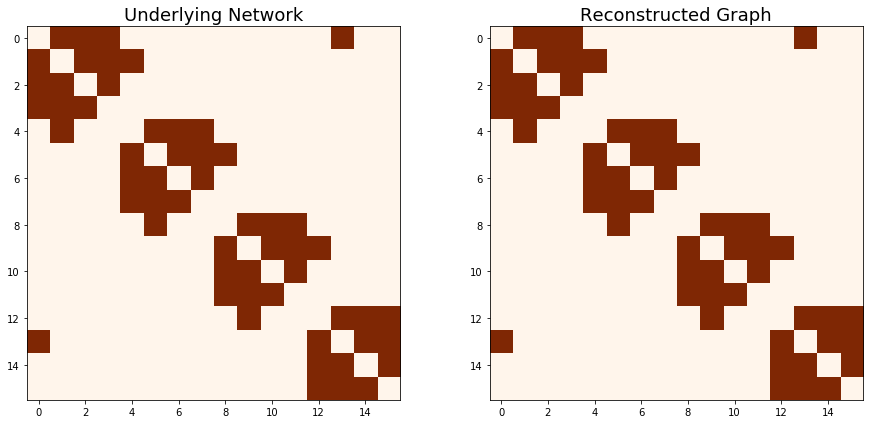

In [6]:
plot_comparison(A, G)

### Sensitivity to Hyperparameters and Time Series Length
It turns out that the current oCSE implementation is prune to the choice of the tolerance `atol`. A high `atol` tends to infer a node having no causal parents while a low `atol` may easily lead to a dense graph. The two figures below demonstrate these scenarios with `atol = 0.1` and `atol = 0.005` respectively:

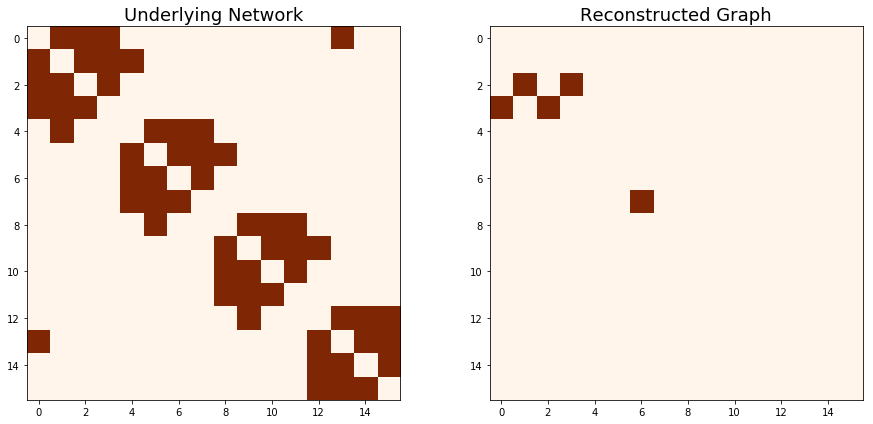

In [7]:
# High tolerance
recon = OptimalCausationEntropyReconstructor()
G = recon.fit(data, n_bins=2, atol=1e-1)

plot_comparison(A, G)

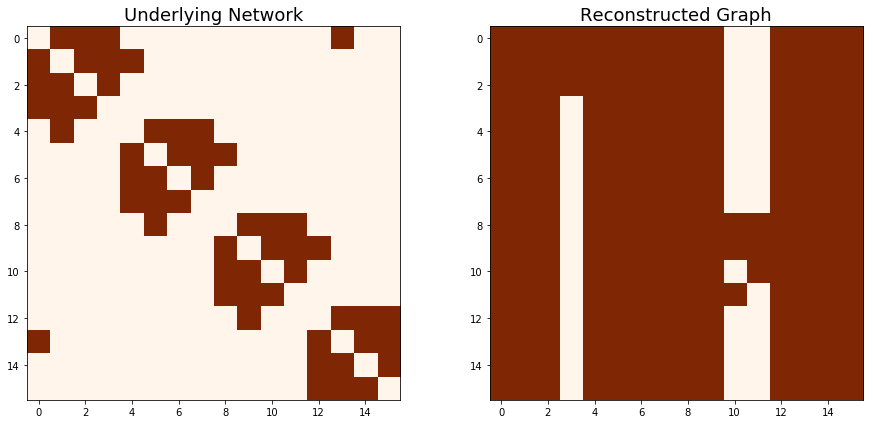

In [8]:
# Low tolerance
recon = OptimalCausationEntropyReconstructor()
G = recon.fit(data, n_bins=2, atol=5e-3)

plot_comparison(A, G)

Furthermore, a good-quality reconstruction requires long enough time series data. Here we apply oCSE to a shorter time series data again with `atol = 0.02`:

In [9]:
L = 200
data = time_series(A, L).T

In [10]:
recon = OptimalCausationEntropyReconstructor()
G = recon.fit(data, n_bins=2, atol=2e-2)

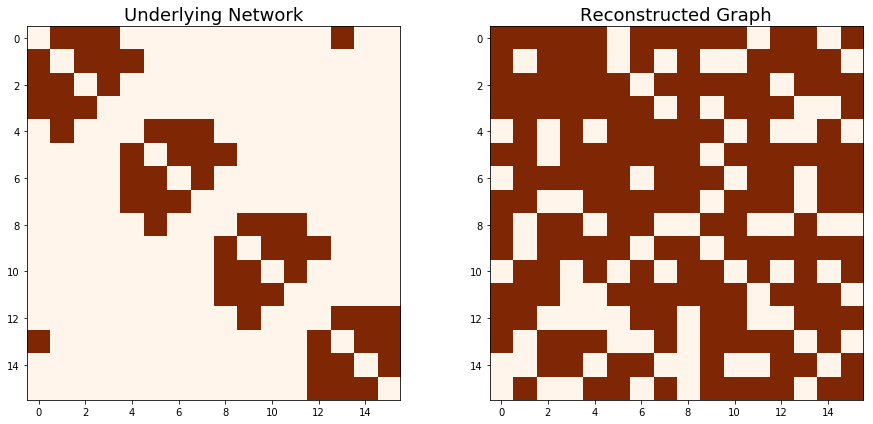

In [11]:
plot_comparison(A, G)

### Potential Resolution
Notice that this sensitivity issue is likely resulted from the current implementation of determing wheter causation entropy is closed to 0, which is a crucial element in the proposed algorithm. Instead of naively thresholding the entropy, **[Sun _et al._](https://epubs.siam.org/doi/10.1137/140956166)** suggested that one applies a permutation test to every causation entropy computed to determine its significance. This potential resolution can be time costly and desires future work for practical usage.